In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import random
import cv2
import seaborn

In [2]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
word_len = [len(sentence) for sentence in train_data]
print("max len: {} min len: {} mean len: {}".format(max(word_len), min(word_len), sum(word_len) // len(word_len)))

max len: 2494 min len: 11 mean len: 238


In [4]:
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k, v in word_index.items()}

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

In [6]:
index_word = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [index_word.get(word_id, "<UNK>") for word_id in text_ids])

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [17]:
embedding_dim = 16
batch_size = 1024

single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.SimpleRNN(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                5184      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [18]:
epochs = 20
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/20
20/20 [==============================] - 9s 382ms/step - loss: 0.6942 - accuracy: 0.5094 - val_loss: 0.6939 - val_accuracy: 0.4918
Epoch 2/20
20/20 [==============================] - 8s 401ms/step - loss: 0.6934 - accuracy: 0.5023 - val_loss: 0.6978 - val_accuracy: 0.4926
Epoch 3/20
20/20 [==============================] - 7s 366ms/step - loss: 0.6938 - accuracy: 0.5036 - val_loss: 0.6935 - val_accuracy: 0.5010
Epoch 4/20
20/20 [==============================] - 7s 368ms/step - loss: 0.6933 - accuracy: 0.5072 - val_loss: 0.6935 - val_accuracy: 0.5066
Epoch 5/20
20/20 [==============================] - 8s 388ms/step - loss: 0.6935 - accuracy: 0.5098 - val_loss: 0.6932 - val_accuracy: 0.5130
Epoch 6/20
20/20 [==============================] - 8s 407ms/step - loss: 0.6935 - accuracy: 0.5034 - val_loss: 0.6958 - val_accuracy: 0.4912
Epoch 7/20
20/20 [==============================] - 7s 349ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6934 - val_accuracy: 0.5002
Epoch 

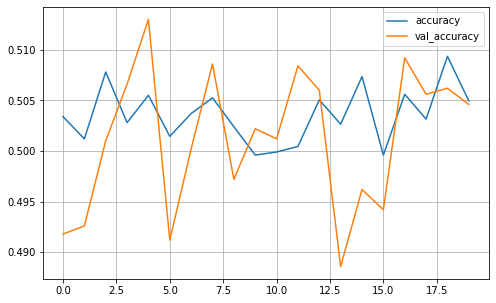

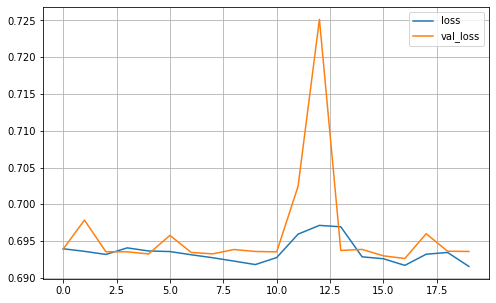

In [19]:
def plot_learning_curves(history, label):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy')
plot_learning_curves(history_single_rnn, 'loss')

In [20]:
bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_bi_rnn = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
20/20 [==============================] - 15s 676ms/step - loss: 0.6938 - accuracy: 0.5034 - val_loss: 0.6929 - val_accuracy: 0.5092
Epoch 2/30
20/20 [==============================] - 13s 658ms/step - loss: 0.6884 - accuracy: 0.5384 - val_loss: 0.6911 - val_accuracy: 0.5220
Epoch 3/30
20/20 [==============================] - 13s 645ms/step - loss: 0.6665 - accuracy: 0.6481 - val_loss: 0.6576 - val_accuracy: 0.6164
Epoch 4/30
20/20 [==============================] - 13s 646ms/step - loss: 0.5800 - accuracy: 0.7153 - val_loss: 0.4910 - val_accuracy: 0.7774
Epoch 5/30
20/20 [==============================] - 13s 678ms/step - loss: 0.3636 - accuracy: 0.8513 - val_loss: 0.4768 - val_accuracy: 0.7876
Epoch 6/30
20/20 [==============================] - 13s 652ms/step - loss: 0.2740 - accuracy: 0.8896 - val_loss: 0.4256 - val_accuracy: 0.8306
Epoch 7/30
20/20 [==============================] - 13s 671ms/step - loss: 0.1543 - accuracy: 0.9489 - val_loss: 0.4449 - val_accuracy: 0.8280

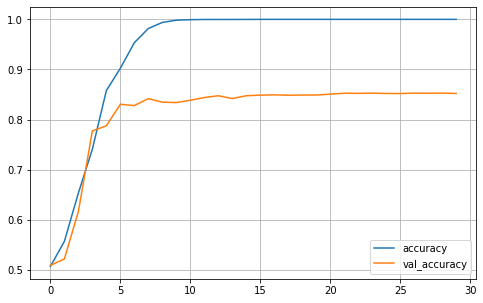

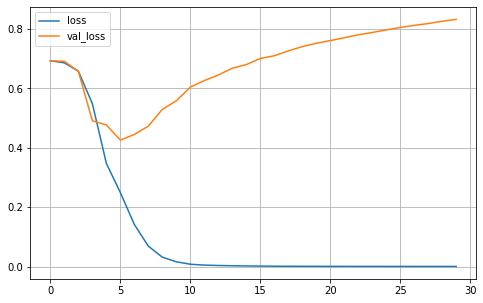

In [22]:
plot_learning_curves(history_bi_rnn, 'accuracy')
plot_learning_curves(history_bi_rnn, 'loss')

In [27]:
bi_rnn_dropout_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 16, return_sequences = False)),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_dropout_model.summary()
bi_rnn_dropout_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_bi_rnn_dropout = bi_rnn_dropout_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
20/20 [==============================] - 15s 680ms/step - loss: 0.6957 - accuracy: 0.5070 - val_loss: 0.6843 - val_accuracy: 0.5900
Epoch 2/30
20/20 [==============================] - 13s 634ms/step - loss: 0.6728 - accuracy: 0.6000 - val_loss: 0.6371 - val_accuracy: 0.7074
Epoch 3/30
20/20 [==============================] - 13s 634ms/step - loss: 0.6227 - accuracy: 0.6939 - val_loss: 0.5441 - val_accuracy: 0.7830
Epoch 4/30
20/20 [==============================] - 14s 688ms/step - loss: 0.5294 - accuracy: 0.7830 - val_loss: 0.4722 - val_accuracy: 0.8140
Epoch 5/30
20/20 [==============================] - 13s 635ms/step - loss: 0.5444 - accuracy: 0.7387 - val_loss: 0.5980 - val_accuracy: 0.6970
Epoch 6/30
20/20 [==============================] - 13s 663ms/step - loss: 0.5639 - accuracy: 0.7301 - val_loss: 0.5461 - val_accuracy: 0.7448
Epoch 7/30
20/20 [==============================] - 13s 634ms/step - loss: 0.4841 - accuracy: 0.8020 - val_loss: 0.4387 - val_accuracy: 0.8166

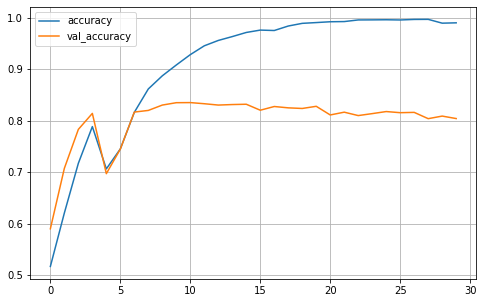

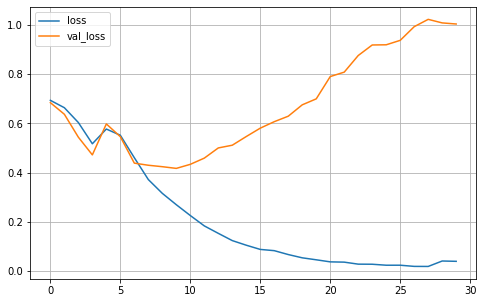

In [29]:
plot_learning_curves(history_bi_rnn_dropout, 'accuracy')
plot_learning_curves(history_bi_rnn_dropout, 'loss')